# Walking-Forward VAR Model with all Variables - Weekly Data

In [112]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 

#import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

**1. Importing the data**

In [113]:
dwfw1 = pd.read_csv("../Data/weekly_data_copy.csv")
dwfw1 = dwfw1.dropna()
dwfw1

,datetime,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s),precipitation (mm),Evapotranspiration (mm),change_rate
1,2013-06-16 00:00:00+00:00,4.796002,3.480797,2.496299,16.676486,970.831971,13.107338,406.125496,123.373230,209.763127,30.3,16.60,-0.000277
2,2013-06-23 00:00:00+00:00,13.144048,7.234524,3.655357,20.507698,968.790704,15.163095,406.084086,129.044798,175.728137,15.2,23.15,-0.000102
3,2013-06-30 00:00:00+00:00,4.705357,6.236905,4.682143,17.990972,976.583929,9.051587,406.065595,99.574583,161.530631,15.1,9.57,-0.000046
4,2013-07-07 00:00:00+00:00,4.802679,5.191964,3.216667,19.244048,974.698611,14.354067,406.074097,93.501548,166.335054,24.4,19.77,0.000021
5,2013-07-14 00:00:00+00:00,15.160119,7.283333,3.213690,20.924008,972.994742,13.282440,406.042024,88.108708,127.600792,0.8,33.60,-0.000079
...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,2019-10-27 00:00:00+00:00,4.669500,3.487500,2.890250,15.683333,970.506333,12.505167,405.981683,48.546900,83.797450,1.2,0.12,-0.000132
335,2019-11-10 00:00:00+00:00,2.236808,1.376560,1.217743,13.145776,958.495248,4.435472,406.010243,53.676705,101.768029,19.0,0.92,0.000070
336,2019-11-17 00:00:00+00:00,3.028010,2.367179,1.946440,11.813492,957.501397,1.788803,405.973240,49.497256,92.721713,5.4,1.63,-0.000091
337,2019-11-24 00:00:00+00:00,3.562667,2.414854,3.232246,10.580124,960.704830,2.868436,405.958604,46.694843,78.703230,0.0,1.14,-0.000036


In [114]:
# convert DateTime column into datetime format
dwfw1["datetime"] = pd.to_datetime(dwfw1['datetime'])
# set DateTime as index
dwfw1.set_index("datetime", inplace=True)
dwfw1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 330 entries, 2013-06-16 00:00:00+00:00 to 2019-12-01 00:00:00+00:00
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   330 non-null    float64
 1   suction_tension (40cm)   330 non-null    float64
 2   suction_tension (70cm)   330 non-null    float64
 3   water_temperature        330 non-null    float64
 4   barometric_pressure_qfe  330 non-null    float64
 5   dew_point                330 non-null    float64
 6   water_level              330 non-null    float64
 7   inflow_linth (m3/s)      330 non-null    float64
 8   outflow_limmat (m3/s)    330 non-null    float64
 9   precipitation (mm)       330 non-null    float64
 10  Evapotranspiration (mm)  330 non-null    float64
 11  change_rate              330 non-null    float64
dtypes: float64(12)
memory usage: 33.5 KB


In [117]:
split_date = '2019-01-07'
dwfw1_train_val = dwfw1.loc[dwfw1.index <= split_date].copy()
dwfw1_test = dwfw1.loc[dwfw1.index > split_date].copy()

,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s),precipitation (mm),Evapotranspiration (mm),change_rate
datetime,,,,,,,,,,,,
2013-06-16 00:00:00+00:00,4.796002,3.480797,2.496299,16.676486,970.831971,13.107338,406.125496,123.373230,209.763127,30.3,16.60,-0.000277
2013-06-23 00:00:00+00:00,13.144048,7.234524,3.655357,20.507698,968.790704,15.163095,406.084086,129.044798,175.728137,15.2,23.15,-0.000102
2013-06-30 00:00:00+00:00,4.705357,6.236905,4.682143,17.990972,976.583929,9.051587,406.065595,99.574583,161.530631,15.1,9.57,-0.000046
2013-07-07 00:00:00+00:00,4.802679,5.191964,3.216667,19.244048,974.698611,14.354067,406.074097,93.501548,166.335054,24.4,19.77,0.000021
2013-07-14 00:00:00+00:00,15.160119,7.283333,3.213690,20.924008,972.994742,13.282440,406.042024,88.108708,127.600792,0.8,33.60,-0.000079
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-09 00:00:00+00:00,2.205060,1.122024,1.550595,9.278175,969.313790,6.386607,405.905764,41.718905,89.459964,53.6,0.69,0.000463
2018-12-16 00:00:00+00:00,3.623512,2.177976,2.254167,7.716171,970.861111,-1.576587,405.916369,46.120637,95.721333,8.7,1.72,0.000026
2018-12-23 00:00:00+00:00,2.686905,1.577381,2.123810,7.123611,972.969940,3.737897,405.881984,42.520363,80.987780,45.4,0.51,-0.000085


**2. Visualizing the Time Series**

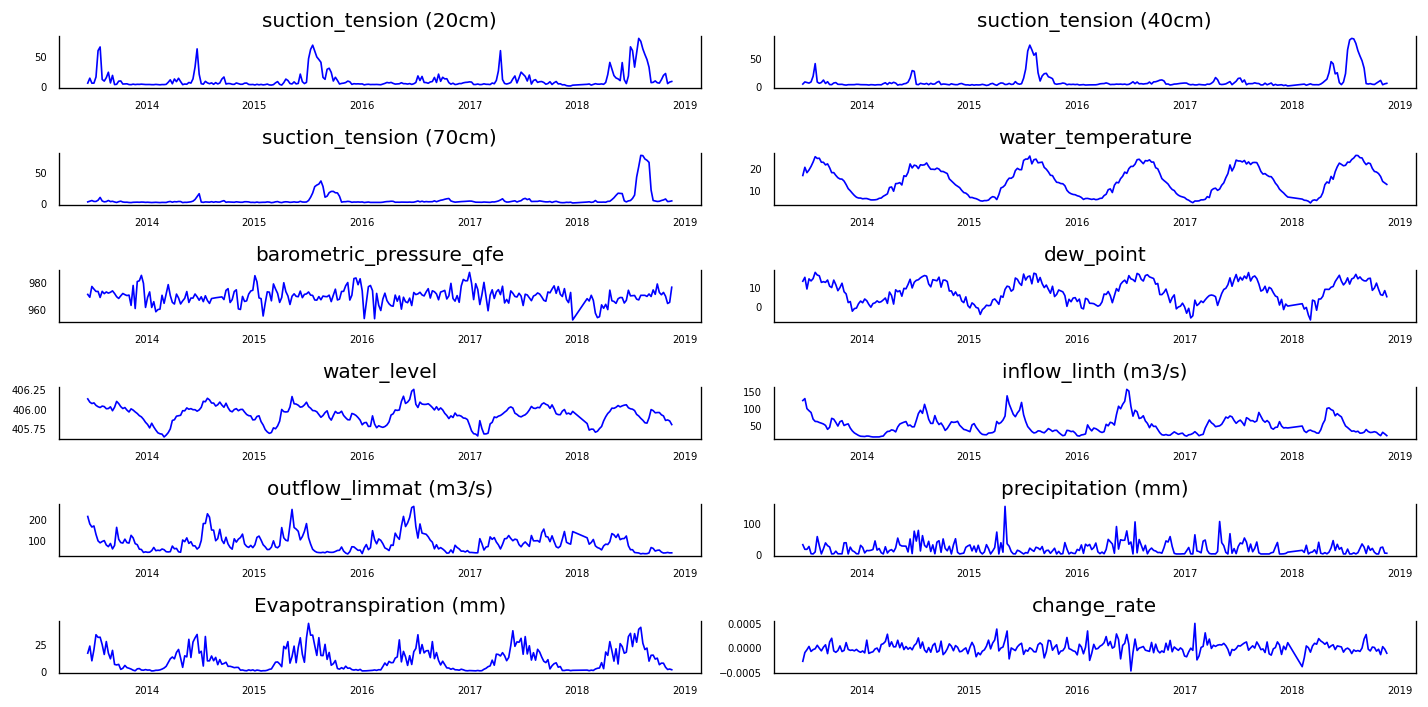

In [61]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = dwfw1[dwfw1.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(dwfw1.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [62]:
# drop variable change rate
dwfw1.drop(columns="change_rate", inplace=True)

**3. Checking for stationarity**

In [63]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [64]:
for name, column in dwfw1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8961
 No. Lags Chosen       = 4
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.1282
 No. Lags Chosen       = 5
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0009. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has 

Here we can see that according to the Augmented Dickey-Fullery Test, all variables are stationary. However we are going to check the auto- and partial autocorrelation to check graphically.

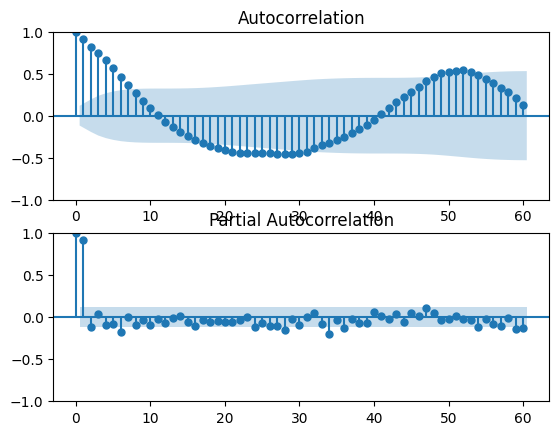

In [65]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(dwfw1["water_level"], lags=60, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(dwfw1["water_level"], lags=60, ax=ax[1])
plt.show()

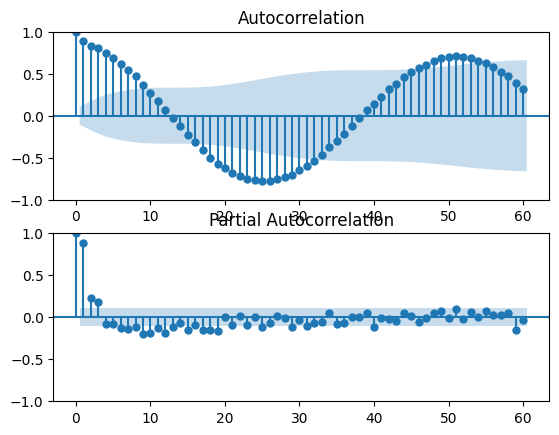

In [18]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(dwfw1["dew_point"], lags=60, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(dwfw1["dew_point"], lags=60, ax=ax[1])
plt.show()

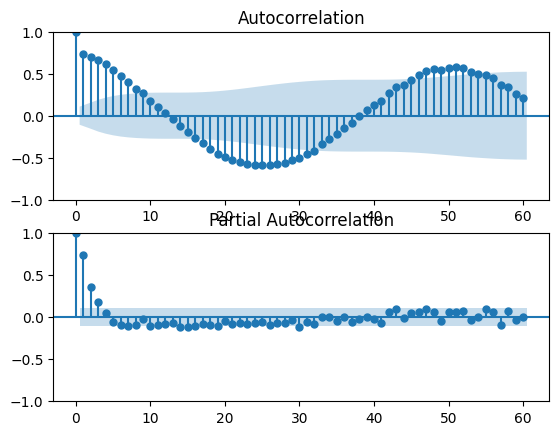

In [19]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(dwfw1["Evapotranspiration (mm)"], lags=60, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(dwfw1["Evapotranspiration (mm)"], lags=60, ax=ax[1])
plt.show()

**4. Splitting the data into train and test set.**

In [66]:
def ts_train_test_split(dwfw1, test_size):
    len_test = int(dwfw1.shape[0]*test_size)
    split_point = dwfw1.index[-len_test]
    dwfw1_train = dwfw1[dwfw1.index < split_point]
    dwfw1_test = dwfw1[dwfw1.index >= split_point]
    
    return dwfw1_train, dwfw1_test


In [84]:
dwfw1_train, dwfw1_test = ts_train_test_split(dwfw1, 0.25)
dwfw1_test

,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s),precipitation (mm),Evapotranspiration (mm)
datetime,,,,,,,,,,,
2017-06-18 00:00:00+00:00,13.695833,5.438690,3.596429,20.654028,971.681468,13.885020,405.902944,64.535411,80.703702,17.5,26.66
2017-06-25 00:00:00+00:00,23.299405,8.476190,4.458929,23.876607,969.607837,16.638532,405.894246,56.369911,70.726589,1.0,30.31
2017-07-02 00:00:00+00:00,19.746429,13.400000,7.097619,23.468849,962.791766,12.969544,405.909375,62.094179,84.585054,24.6,15.59
2017-07-09 00:00:00+00:00,16.136310,14.016964,8.154762,23.453810,970.974246,15.220913,405.921006,65.735107,92.994756,36.0,31.88
2017-07-16 00:00:00+00:00,8.374405,6.899107,6.162500,23.014325,970.436786,13.722857,405.946058,58.642256,82.979488,33.2,15.89
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-21 00:00:00+00:00,17.838885,7.852614,5.636801,17.564415,972.275794,8.920592,405.906392,24.186838,42.192287,0.0,7.35
2018-10-28 00:00:00+00:00,20.970044,9.924884,7.192417,16.199174,969.550662,6.096157,405.848070,19.969953,42.743754,20.6,3.65
2018-11-04 00:00:00+00:00,3.954775,2.349457,3.010067,13.886404,964.261555,5.757196,405.855001,29.858464,44.703866,22.4,1.58


In [85]:
varmodel2 = VAR(dwfw1_train)
varmodel2.select_order(maxlags=9).summary()

,AIC,BIC,FPE,HQIC
0,32.77,32.95,1.704e+14,32.84
1,22.22,24.39*,4.461e+09,23.10*
2,21.92*,26.09,3.338e+09*,23.61
3,22.18,28.35,4.442e+09,24.67
4,22.50,30.66,6.416e+09,25.80
5,22.92,33.07,1.060e+10,27.03
6,22.97,35.13,1.273e+10,27.89
7,22.84,36.99,1.337e+10,28.56
8,22.66,38.81,1.454e+10,29.20
9,22.65,40.79,2.038e+10,29.99


In [86]:
# creating a walk forward fuction that will split a time series into training and testing set, and return a tuple of the test set 
# and the predicited test set
def walk_forward_VAR(dwfw1, test_size, lag_order):
    # splitting the data into train and test set
    dwfw1_train, dwfw1_test = ts_train_test_split(dwfw1, test_size)
 
    # makes a list of lists from the train set
    history = [list(x) for x in np.array(dwfw1_train)] 
    forecasts = [] # empty list to store our forecasts
    
    for t in range(dwfw1_test.shape[0]): # for each test set,
        # initialize a VAR model on the train set,
        model = VAR(np.array(history)) 
        model_fit = model.fit(lag_order) # fits the model
        
        # forecast just the next time step
        yhat = model_fit.forecast(model.y, steps=1)
        
        # add the forecast to the forecasts list
        forecasts.append(list(yhat[0])) 
        
        # add the actual test value as the last observation of the 
        # train set
        history.append(list(np.array(dwfw1_test)[t])) 
            
    # return a tuple of the test set and the predicited test set as
    # a tuple of dataframes 
    return dwfw1_test, pd.DataFrame(np.array(forecasts), index=dwfw1_test.index, columns=dwfw1.columns)

In [109]:
dwfw1_results_test, dwfw1_results_pred = walk_forward_VAR(dwfw1, 0.25, 0)

IndexError: index 0 is out of bounds for axis 0 with size 0

<AxesSubplot: xlabel='datetime'>

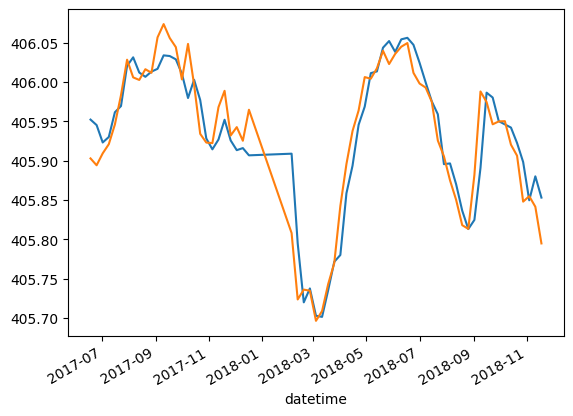

In [ ]:
import matplotlib.pyplot as plt
dwfw1_results_pred["water_level"].plot()
dwfw1_results_test["water_level"].plot()

In [110]:
# defining mean absolute percentage error (MAPE) metric
def mape(df_true, df_pred):
    
    error = df_true - df_pred # calculates the error
    
    return 100 * np.mean(np.abs(error/df_true), axis=0) # resturns the MAPE
 
# importing mean square error
from sklearn.metrics import mean_squared_error as mse

# defining a function to return a dataframe of rmse and mape scores
def get_rmse_and_mape(df_true, df_pred):
    results = {'RMSE': mse(np.array(df_true), np.array(df_pred), multioutput='raw_values', squared=False), 
               'MAPE (%)': mape(np.array(df_true), np.array(df_pred))}
    
    return pd.DataFrame(results, index=df_true.columns)

In [111]:
get_rmse_and_mape(dwfw1_results_pred, dwfw1_results_test)

,RMSE,MAPE (%)
suction_tension (20cm),10.227981,67.794179
suction_tension (40cm),7.523495,63.095391
suction_tension (70cm),6.486354,34.872954
water_temperature,1.205849,6.836399
barometric_pressure_qfe,4.742039,0.359087
dew_point,2.560435,170.511196
water_level,0.033388,0.006021
inflow_linth (m3/s),8.627598,13.611886
outflow_limmat (m3/s),18.968911,19.178124
precipitation (mm),16.365544,87.756257


In [104]:
0.25, 1
RMSE	MAPE (%)
suction_tension (20cm)	10.227981	67.794179
suction_tension (40cm)	7.523495	63.095391
suction_tension (70cm)	6.486354	34.872954
water_temperature	1.205849	6.836399
barometric_pressure_qfe	4.742039	0.359087
dew_point	2.560435	170.511196
water_level	0.033388	0.006021
inflow_linth (m3/s)	8.627598	13.611886
outflow_limmat (m3/s)	18.968911	19.178124
precipitation (mm)	16.365544	87.756257
Evapotranspiration (mm)	7.242742	58.099841

0.25, 2
RMSE	MAPE (%)
suction_tension (20cm)	9.969429	125.384466
suction_tension (40cm)	8.257203	56.336220
suction_tension (70cm)	6.437094	45.950455
water_temperature	1.065919	6.459238
barometric_pressure_qfe	5.064189	0.381521
dew_point	2.524131	63.837590
water_level	0.032663	0.006114
inflow_linth (m3/s)	8.803026	14.013747
outflow_limmat (m3/s)	20.248590	20.984766
precipitation (mm)	17.645120	86.642233
Evapotranspiration (mm)	6.808671	76.764100

0.25, 3
RMSE	MAPE (%)
suction_tension (20cm)	10.723108	90.339387
suction_tension (40cm)	8.486010	55.576502
suction_tension (70cm)	7.065454	46.030745
water_temperature	1.051969	6.303766
barometric_pressure_qfe	5.295379	0.403703
dew_point	2.522175	113.444803
water_level	0.033700	0.006154
inflow_linth (m3/s)	8.875704	14.795367
outflow_limmat (m3/s)	19.768793	19.665632
precipitation (mm)	20.163561	145.813108
Evapotranspiration (mm)	7.379010	92.096933

0.25, 4
RMSE	MAPE (%)
suction_tension (20cm)	13.201982	88.798508
suction_tension (40cm)	9.641948	89.653868
suction_tension (70cm)	7.523097	57.244099
water_temperature	1.089705	6.630435
barometric_pressure_qfe	5.581192	0.419985
dew_point	2.733058	52.811555
water_level	0.035318	0.006771
inflow_linth (m3/s)	9.593204	16.854686
outflow_limmat (m3/s)	20.711343	32.722852
precipitation (mm)	22.832794	193.204026
Evapotranspiration (mm)	7.881140	79.083227

0.25, 5
RMSE	MAPE (%)
suction_tension (20cm)	13.034960	97.824272
suction_tension (40cm)	10.327234	109.606399
suction_tension (70cm)	8.192596	86.546421
water_temperature	1.158766	7.084301
barometric_pressure_qfe	5.842644	0.440033
dew_point	2.865839	175.307124
water_level	0.036495	0.007286
inflow_linth (m3/s)	9.678783	17.106389
outflow_limmat (m3/s)	22.209249	32.701373
precipitation (mm)	23.738288	409.966363
Evapotranspiration (mm)	8.338093	80.020817

0.25, 

SyntaxError: invalid syntax (1979856046.py, line 2)